# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# import libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import time
from xgboost.sklearn import XGBClassifier #sklearn wrapper for xgboost
from sklearn import metrics 
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pylab as plt 
%matplotlib inline 
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 12, 4

In [2]:
df_train = pd.read_pickle('../input/processed_data.pickle')
df_train.dropna(subset=['shot_made_flag'], inplace=True)
df_train.dropna(subset=['MA200'], inplace=True)
df_train.shape

(25538, 195)

In [3]:
def modelfit(model, df, features, label, scoring='accuracy', performCV=True, printFeatureImportance=True, cv_folds=5):
    ''' 
    parameters
    ----------
        model
        df dataframe
            the dataframe with the training data
        features list
            list of features to keep for training            
        label string
            name of label
        performCV boolean
            True to get a CV score
        printFeatureImportance
            True to plot the features importance
        cv_folds
        
    '''
    
    # fit the algoritm on the data
    model.fit(df[features], df[label])
    
    # predict training set
    df_predictions = model.predict(df[features])
    df_proba = model.predict_proba(df[features])[:,1]
    
    # perform cross-validation
    if performCV:
        cv_score = cross_val_score(model, df[features], df[label], cv=cv_folds, scoring=scoring)
    
    # print report
    print('\nModel Report')
    print('Accuracy: %.4g' % metrics.accuracy_score(df[label].values, df_predictions))
    print('AUC Score (Train): %f' % metrics.roc_auc_score(df[label], df_proba))
    
    if performCV:
        print('CV score (%s): Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g' % (scoring,np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    # Print Feature Importance: 
    if printFeatureImportance: 
        feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances') 
        plt.ylabel('Feature Importance Score')       
                

In [4]:
# fix learning rate
learning_rate = 0.1

# set initial values
max_depth = 5 # should be between 3 and 10
min_child_weight = 1
gamma = 0
subsample = 0.8
colsample_bytree = 0.8
scale_pos_weight = 1

In [5]:
# choose all features
features = df_train.drop(['shot_id','game_date','shot_made_flag'],axis=1).columns


Model Report
Accuracy: 0.8999
AUC Score (Train): 0.968608
CV score (neg_log_loss): Mean - -0.8423629 | Std - 0.1033907 | Min - -0.9511981 | Max - -0.6564863


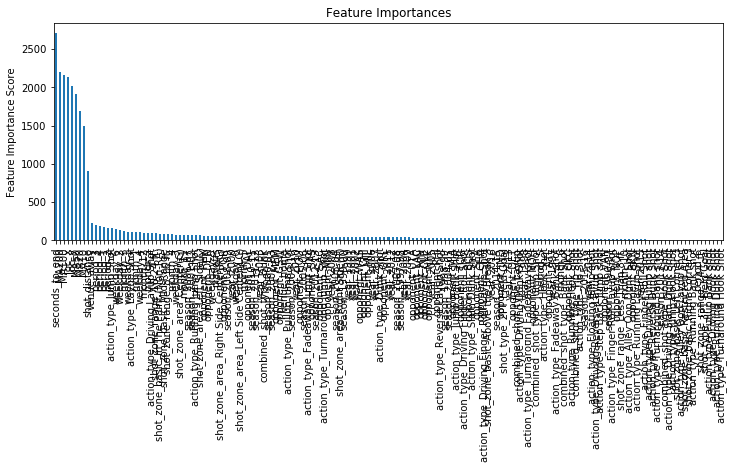

In [6]:
# get baseline performance
xgb1 = XGBClassifier(learning_rate =0.1,
                     n_estimators=1000,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)

modelfit(xgb1, df_train, features, 'shot_made_flag', 'neg_log_loss')

In [31]:
def tune_model(model, df, features, label, params, scoring='accuracy'):
    ''' run a GridSearchCV optimization on a mode
    parameters
    ----------
        model
            the model to be optimized
        df    dataframe
        features    list
        label    string
        params    dictionary
            the parameters to be tested
    return
    --------
        better_model
            a model with optimized parameters
    
    '''
    
    gsearch = GridSearchCV(estimator = model,
                           param_grid = params,
                           scoring = scoring,
                           n_jobs=4,
                           iid=False,
                           cv=10, 
                           verbose = 10)
    
    gsearch.fit(df[features], df[label])
    
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    
    return gsearch.best_estimator_

In [21]:
xgb1 = XGBClassifier(learning_rate =0.1,
                     n_estimators=140,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)

param_test1 = {'max_depth':range(3,10,2),
               'min_child_weight':range(1,6,2)}

best_model = tune_model(xgb1, df_train, features, 'shot_made_flag', param_test1, 'neg_log_loss')

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV] . max_depth=3, min_child_weight=1, score=-0.862292, total=  20.0s
[CV] . max_depth=3, min_child_weight=1, score=-0.775235, total=  19.9s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV] . max_depth=3, min_child_weight=1, score=-0.550164, total=  20.8s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] . max_depth=3, min_child_weight=1, score=-0.557607, total=  21.0s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] . max_depth=3, min_child_weight=1, score=-0.620746, total=  20.7s
[CV] max_depth

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   42.5s


[CV] . max_depth=3, min_child_weight=1, score=-0.575722, total=  21.2s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] . max_depth=3, min_child_weight=1, score=-0.968633, total=  20.4s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] . max_depth=3, min_child_weight=1, score=-1.332151, total=  21.1s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] . max_depth=3, min_child_weight=1, score=-0.731719, total=  18.3s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] . max_depth=3, min_child_weight=3, score=-0.550042, total=  19.7s
[CV] max_depth=3, min_child_weight=3 .................................


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.1min


[CV] . max_depth=3, min_child_weight=3, score=-0.897899, total=  20.1s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] . max_depth=3, min_child_weight=1, score=-1.869073, total=  22.2s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] . max_depth=3, min_child_weight=3, score=-0.750089, total=  20.5s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] . max_depth=3, min_child_weight=3, score=-0.557541, total=  20.1s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] . max_depth=3, min_child_weight=3, score=-0.573815, total=  19.9s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] . max_depth=3, min_child_weight=3, score=-0.610862, total=  22.1s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] . max_depth=3, min_child_weight=3, score=-1.917156, total=  20.3s
[CV] max_depth=3, min_child_weight=5 .................................


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.8min


[CV] . max_depth=3, min_child_weight=3, score=-1.350943, total=  22.7s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] . max_depth=3, min_child_weight=3, score=-0.959330, total=  22.6s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] . max_depth=3, min_child_weight=3, score=-0.720580, total=  22.7s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] . max_depth=3, min_child_weight=5, score=-0.793700, total=  20.4s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] . max_depth=3, min_child_weight=5, score=-0.549698, total=  22.3s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] . max_depth=3, min_child_weight=5, score=-0.690399, total=  20.7s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] . max_depth=3, min_child_weight=5, score=-0.557130, total=  20.2s
[CV] max_depth=3, min_child_weight=5 .................................


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.2min


[CV] . max_depth=3, min_child_weight=5, score=-0.572090, total=  19.9s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] . max_depth=3, min_child_weight=5, score=-1.276387, total=  20.1s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] . max_depth=3, min_child_weight=5, score=-0.614773, total=  21.2s
[CV] max_depth=5, min_child_weight=1 .................................
[CV] . max_depth=3, min_child_weight=5, score=-0.922263, total=  20.2s
[CV] max_depth=5, min_child_weight=1 .................................
[CV] . max_depth=3, min_child_weight=5, score=-1.867784, total=  19.8s
[CV] max_depth=5, min_child_weight=1 .................................
[CV] . max_depth=3, min_child_weight=5, score=-0.724157, total=  19.9s
[CV] max_depth=5, min_child_weight=1 .................................
[CV] . max_depth=5, min_child_weight=1, score=-0.553977, total=  33.1s
[CV] max_depth=5, min_child_weight=1 .................................
[CV] .

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.4min


[CV] . max_depth=5, min_child_weight=1, score=-0.564795, total=  32.5s
[CV] max_depth=5, min_child_weight=1 .................................
[CV] . max_depth=5, min_child_weight=1, score=-0.580934, total=  32.1s
[CV] max_depth=5, min_child_weight=1 .................................
[CV] . max_depth=5, min_child_weight=1, score=-0.651538, total=  33.8s
[CV] max_depth=5, min_child_weight=1 .................................
[CV] . max_depth=5, min_child_weight=1, score=-1.512834, total=  32.5s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] . max_depth=5, min_child_weight=1, score=-1.129025, total=  33.0s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] . max_depth=5, min_child_weight=1, score=-2.194197, total=  31.7s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] . max_depth=5, min_child_weight=1, score=-0.802241, total=  31.1s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] .

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.5min


[CV] . max_depth=5, min_child_weight=3, score=-0.784859, total=  33.5s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] . max_depth=5, min_child_weight=3, score=-0.564173, total=  33.0s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] . max_depth=5, min_child_weight=3, score=-0.578438, total=  32.7s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] . max_depth=5, min_child_weight=3, score=-0.644164, total=  32.8s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] . max_depth=5, min_child_weight=3, score=-1.457477, total=  31.8s
[CV] max_depth=5, min_child_weight=5 .................................
[CV] . max_depth=5, min_child_weight=3, score=-1.113177, total=  32.0s
[CV] max_depth=5, min_child_weight=5 .................................
[CV] . max_depth=5, min_child_weight=3, score=-2.135131, total=  33.6s
[CV] max_depth=5, min_child_weight=5 .................................
[CV] .

[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  6.2min


[CV] . max_depth=5, min_child_weight=5, score=-0.559789, total=  32.7s
[CV] max_depth=5, min_child_weight=5 .................................
[CV] . max_depth=5, min_child_weight=5, score=-0.578291, total=  32.8s
[CV] max_depth=5, min_child_weight=5 .................................
[CV] . max_depth=5, min_child_weight=5, score=-0.621400, total=  31.9s
[CV] max_depth=5, min_child_weight=5 .................................
[CV] . max_depth=5, min_child_weight=5, score=-1.367717, total=  33.1s
[CV] max_depth=7, min_child_weight=1 .................................
[CV] . max_depth=5, min_child_weight=5, score=-0.986498, total=  31.4s
[CV] max_depth=7, min_child_weight=1 .................................
[CV] . max_depth=5, min_child_weight=5, score=-1.875219, total=  32.5s
[CV] max_depth=7, min_child_weight=1 .................................
[CV] . max_depth=5, min_child_weight=5, score=-0.790413, total=  32.6s
[CV] max_depth=7, min_child_weight=1 .................................
[CV] .

[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  7.8min


[CV] . max_depth=7, min_child_weight=1, score=-0.591835, total=  43.9s
[CV] max_depth=7, min_child_weight=1 .................................
[CV] . max_depth=7, min_child_weight=1, score=-0.661261, total=  46.3s
[CV] max_depth=7, min_child_weight=1 .................................
[CV] . max_depth=7, min_child_weight=1, score=-1.578604, total=  48.6s
[CV] max_depth=7, min_child_weight=3 .................................
[CV] . max_depth=7, min_child_weight=1, score=-1.251097, total=  46.6s
[CV] max_depth=7, min_child_weight=3 .................................
[CV] . max_depth=7, min_child_weight=1, score=-2.239856, total=  44.5s
[CV] max_depth=7, min_child_weight=3 .................................
[CV] . max_depth=7, min_child_weight=1, score=-0.867626, total=  47.0s
[CV] max_depth=7, min_child_weight=3 .................................
[CV] . max_depth=7, min_child_weight=3, score=-0.561522, total=  45.4s
[CV] max_depth=7, min_child_weight=3 .................................
[CV] .

[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 10.6min


[CV] . max_depth=7, min_child_weight=3, score=-1.150702, total=  45.9s
[CV] max_depth=7, min_child_weight=5 .................................
[CV] . max_depth=7, min_child_weight=3, score=-2.093225, total=  43.6s
[CV] max_depth=7, min_child_weight=5 .................................
[CV] . max_depth=7, min_child_weight=3, score=-0.828144, total=  44.6s
[CV] max_depth=7, min_child_weight=5 .................................
[CV] . max_depth=7, min_child_weight=5, score=-0.561333, total=  43.3s
[CV] max_depth=7, min_child_weight=5 .................................
[CV] . max_depth=7, min_child_weight=5, score=-0.776535, total=  45.1s
[CV] max_depth=7, min_child_weight=5 .................................
[CV] . max_depth=7, min_child_weight=5, score=-0.784145, total=  44.9s
[CV] max_depth=7, min_child_weight=5 .................................
[CV] . max_depth=7, min_child_weight=5, score=-0.574367, total=  46.7s
[CV] max_depth=7, min_child_weight=5 .................................
[CV] .

[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 13.0min


[CV] . max_depth=9, min_child_weight=1, score=-0.568385, total=  58.3s
[CV] max_depth=9, min_child_weight=1 .................................
[CV] . max_depth=9, min_child_weight=1, score=-1.041547, total=  59.0s
[CV] max_depth=9, min_child_weight=1 .................................
[CV] . max_depth=9, min_child_weight=1, score=-0.866356, total= 1.0min
[CV] max_depth=9, min_child_weight=1 .................................
[CV] . max_depth=9, min_child_weight=1, score=-0.580158, total=  59.4s
[CV] max_depth=9, min_child_weight=1 .................................
[CV] . max_depth=9, min_child_weight=1, score=-0.604896, total= 1.0min
[CV] max_depth=9, min_child_weight=1 .................................
[CV] . max_depth=9, min_child_weight=1, score=-0.663541, total=  58.5s
[CV] max_depth=9, min_child_weight=1 .................................
[CV] . max_depth=9, min_child_weight=1, score=-1.626412, total= 1.0min
[CV] max_depth=9, min_child_weight=3 .................................
[CV] .

[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed: 16.8min


[CV] . max_depth=9, min_child_weight=3, score=-0.659669, total= 1.0min
[CV] max_depth=9, min_child_weight=3 .................................
[CV] . max_depth=9, min_child_weight=3, score=-1.479247, total=  57.9s
[CV] max_depth=9, min_child_weight=5 .................................
[CV] . max_depth=9, min_child_weight=3, score=-1.144145, total= 1.0min
[CV] max_depth=9, min_child_weight=5 .................................
[CV] . max_depth=9, min_child_weight=3, score=-2.065520, total=  57.5s
[CV] max_depth=9, min_child_weight=5 .................................
[CV] . max_depth=9, min_child_weight=3, score=-0.868100, total=  59.6s
[CV] max_depth=9, min_child_weight=5 .................................
[CV] . max_depth=9, min_child_weight=5, score=-0.564285, total=  57.7s
[CV] max_depth=9, min_child_weight=5 .................................
[CV] . max_depth=9, min_child_weight=5, score=-0.759122, total=  59.9s
[CV] max_depth=9, min_child_weight=5 .................................
[CV] .

[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed: 20.2min finished


{'split6_train_score': array([-0.53375149, -0.5343736 , -0.53501044, -0.49891589, -0.50528596,
       -0.50659417, -0.43815816, -0.44968393, -0.46022331, -0.35747864,
       -0.38920378, -0.40296472]), 'mean_score_time': array([ 0.10503328,  0.11558559,  0.10441458,  0.12957146,  0.11476114,
        0.11134758,  0.1375936 ,  0.13370817,  0.12142363,  0.14107752,
        0.13768837,  0.12369306]), 'mean_test_score': array([-0.88433423, -0.88882577, -0.85683817, -0.98263211, -0.95906419,
       -0.88482976, -1.0187188 , -0.97146637, -0.89865653, -1.04623897,
       -0.97152147, -0.89352128]), 'split3_train_score': array([-0.53902615, -0.53936983, -0.54047686, -0.50149428, -0.50849053,
       -0.50960361, -0.44007595, -0.45173349, -0.46070697, -0.35314469,
       -0.38681612, -0.40574076]), 'split2_train_score': array([-0.53790363, -0.53872867, -0.53882738, -0.50351678, -0.50691038,
       -0.50828805, -0.43662339, -0.45072165, -0.45903368, -0.35064743,
       -0.38337857, -0.40133519]), 

In [22]:
best_model

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=140, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

In [25]:
# We’ll search for values 1 above and below the optimum values because we took an interval of two.

param_test2 = {'max_depth':[2,3,4],
               'min_child_weight':[4,5,6]}

best_model = tune_model(best_model, df_train, features, 'shot_made_flag', param_test2, 'neg_log_loss')

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV] max_depth=2, min_child_weight=4 .................................
[CV] max_depth=2, min_child_weight=4 .................................
[CV] max_depth=2, min_child_weight=4 .................................
[CV] max_depth=2, min_child_weight=4 .................................
[CV] . max_depth=2, min_child_weight=4, score=-0.799693, total=  14.3s
[CV] max_depth=2, min_child_weight=4 .................................
[CV] . max_depth=2, min_child_weight=4, score=-0.552940, total=  15.0s
[CV] . max_depth=2, min_child_weight=4, score=-0.550681, total=  15.0s
[CV] max_depth=2, min_child_weight=4 .................................
[CV] max_depth=2, min_child_weight=4 .................................
[CV] . max_depth=2, min_child_weight=4, score=-0.720066, total=  15.2s
[CV] max_depth=2, min_child_weight=4 .................................
[CV] . max_depth=2, min_child_weight=4, score=-1.219359, total=  13.2s
[CV] max_depth=2

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   29.9s


[CV] . max_depth=2, min_child_weight=4, score=-0.582560, total=  14.0s
[CV] max_depth=2, min_child_weight=4 .................................
[CV] . max_depth=2, min_child_weight=4, score=-0.568942, total=  14.8s
[CV] max_depth=2, min_child_weight=5 .................................
[CV] . max_depth=2, min_child_weight=4, score=-0.853320, total=  16.1s
[CV] max_depth=2, min_child_weight=5 .................................
[CV] . max_depth=2, min_child_weight=5, score=-0.550887, total=  15.5s
[CV] . max_depth=2, min_child_weight=4, score=-0.677298, total=  15.9s
[CV] max_depth=2, min_child_weight=5 .................................
[CV] max_depth=2, min_child_weight=5 .................................


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   47.4s


[CV] . max_depth=2, min_child_weight=4, score=-1.614966, total=  17.1s
[CV] max_depth=2, min_child_weight=5 .................................
[CV] . max_depth=2, min_child_weight=5, score=-0.776731, total=  16.6s
[CV] max_depth=2, min_child_weight=5 .................................
[CV] . max_depth=2, min_child_weight=5, score=-0.687782, total=  15.7s
[CV] max_depth=2, min_child_weight=5 .................................
[CV] . max_depth=2, min_child_weight=5, score=-0.566374, total=  15.5s
[CV] max_depth=2, min_child_weight=5 .................................
[CV] . max_depth=2, min_child_weight=5, score=-0.551314, total=  16.5s
[CV] max_depth=2, min_child_weight=5 .................................
[CV] . max_depth=2, min_child_weight=5, score=-0.582525, total=  15.4s
[CV] max_depth=2, min_child_weight=5 .................................
[CV] . max_depth=2, min_child_weight=5, score=-1.187791, total=  14.6s
[CV] max_depth=2, min_child_weight=6 .................................


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.3min


[CV] . max_depth=2, min_child_weight=5, score=-0.858420, total=  14.3s
[CV] max_depth=2, min_child_weight=6 .................................
[CV] . max_depth=2, min_child_weight=5, score=-1.646628, total=  15.9s
[CV] max_depth=2, min_child_weight=6 .................................
[CV] . max_depth=2, min_child_weight=5, score=-0.677518, total=  15.0s
[CV] max_depth=2, min_child_weight=6 .................................
[CV] . max_depth=2, min_child_weight=6, score=-0.551021, total=  14.3s
[CV] max_depth=2, min_child_weight=6 .................................
[CV] . max_depth=2, min_child_weight=6, score=-0.735615, total=  14.5s
[CV] max_depth=2, min_child_weight=6 .................................
[CV] . max_depth=2, min_child_weight=6, score=-0.629811, total=  14.4s
[CV] max_depth=2, min_child_weight=6 .................................
[CV] . max_depth=2, min_child_weight=6, score=-0.552933, total=  16.1s
[CV] max_depth=2, min_child_weight=6 .................................


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.7min


[CV] . max_depth=2, min_child_weight=6, score=-0.580278, total=  13.5s
[CV] max_depth=2, min_child_weight=6 .................................
[CV] . max_depth=2, min_child_weight=6, score=-0.568576, total=  15.3s
[CV] max_depth=2, min_child_weight=6 .................................
[CV] . max_depth=2, min_child_weight=6, score=-1.209623, total=  15.7s
[CV] max_depth=3, min_child_weight=4 .................................
[CV] . max_depth=2, min_child_weight=6, score=-0.876184, total=  15.3s
[CV] max_depth=3, min_child_weight=4 .................................
[CV] . max_depth=2, min_child_weight=6, score=-1.613971, total=  15.7s
[CV] max_depth=3, min_child_weight=4 .................................
[CV] . max_depth=2, min_child_weight=6, score=-0.675248, total=  15.7s
[CV] max_depth=3, min_child_weight=4 .................................
[CV] . max_depth=3, min_child_weight=4, score=-0.550447, total=  21.4s
[CV] max_depth=3, min_child_weight=4 .................................
[CV] .

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.4min


[CV] . max_depth=3, min_child_weight=4, score=-0.555759, total=  21.0s
[CV] max_depth=3, min_child_weight=4 .................................
[CV] . max_depth=3, min_child_weight=4, score=-0.572837, total=  20.7s
[CV] max_depth=3, min_child_weight=4 .................................
[CV] . max_depth=3, min_child_weight=4, score=-0.607839, total=  21.3s
[CV] max_depth=3, min_child_weight=4 .................................
[CV] . max_depth=3, min_child_weight=4, score=-1.342858, total=  20.9s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] . max_depth=3, min_child_weight=4, score=-0.928161, total=  20.5s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] . max_depth=3, min_child_weight=4, score=-1.891909, total=  19.9s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] . max_depth=3, min_child_weight=4, score=-0.732698, total=  20.1s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] .

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.2min


[CV] . max_depth=3, min_child_weight=5, score=-0.690399, total=  20.7s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] . max_depth=3, min_child_weight=5, score=-0.557130, total=  20.8s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] . max_depth=3, min_child_weight=5, score=-0.572090, total=  20.7s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] . max_depth=3, min_child_weight=5, score=-0.614773, total=  20.3s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] . max_depth=3, min_child_weight=5, score=-1.276387, total=  21.0s
[CV] max_depth=3, min_child_weight=6 .................................
[CV] . max_depth=3, min_child_weight=5, score=-0.922263, total=  19.7s
[CV] max_depth=3, min_child_weight=6 .................................
[CV] . max_depth=3, min_child_weight=5, score=-1.867784, total=  20.8s
[CV] max_depth=3, min_child_weight=6 .................................
[CV] .

[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  4.2min


[CV] . max_depth=3, min_child_weight=6, score=-0.557193, total=  22.3s
[CV] max_depth=3, min_child_weight=6 .................................
[CV] . max_depth=3, min_child_weight=6, score=-0.572983, total=  20.5s
[CV] max_depth=3, min_child_weight=6 .................................
[CV] . max_depth=3, min_child_weight=6, score=-0.615723, total=  20.4s
[CV] max_depth=3, min_child_weight=6 .................................
[CV] . max_depth=3, min_child_weight=6, score=-1.217337, total=  22.0s
[CV] max_depth=4, min_child_weight=4 .................................
[CV] . max_depth=3, min_child_weight=6, score=-0.962444, total=  22.8s
[CV] max_depth=4, min_child_weight=4 .................................
[CV] . max_depth=3, min_child_weight=6, score=-1.765286, total=  21.9s
[CV] max_depth=4, min_child_weight=4 .................................
[CV] . max_depth=3, min_child_weight=6, score=-0.724971, total=  22.7s
[CV] max_depth=4, min_child_weight=4 .................................
[CV] .

[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  5.4min


[CV] . max_depth=4, min_child_weight=4, score=-0.573627, total=  29.6s
[CV] max_depth=4, min_child_weight=4 .................................
[CV] . max_depth=4, min_child_weight=4, score=-0.644516, total=  30.1s
[CV] max_depth=4, min_child_weight=4 .................................
[CV] . max_depth=4, min_child_weight=4, score=-1.413554, total=  28.3s
[CV] max_depth=4, min_child_weight=5 .................................
[CV] . max_depth=4, min_child_weight=4, score=-1.018581, total=  28.7s
[CV] max_depth=4, min_child_weight=5 .................................
[CV] . max_depth=4, min_child_weight=4, score=-1.996301, total=  30.3s
[CV] max_depth=4, min_child_weight=5 .................................
[CV] . max_depth=4, min_child_weight=4, score=-0.785180, total=  30.4s
[CV] max_depth=4, min_child_weight=5 .................................
[CV] . max_depth=4, min_child_weight=5, score=-0.552200, total=  28.6s
[CV] max_depth=4, min_child_weight=5 .................................
[CV] .

[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  7.2min


[CV] . max_depth=4, min_child_weight=5, score=-1.866650, total=  27.4s
[CV] max_depth=4, min_child_weight=6 .................................
[CV] . max_depth=4, min_child_weight=5, score=-0.988976, total=  29.2s
[CV] max_depth=4, min_child_weight=6 .................................
[CV] . max_depth=4, min_child_weight=5, score=-0.767128, total=  28.0s
[CV] max_depth=4, min_child_weight=6 .................................
[CV] . max_depth=4, min_child_weight=6, score=-0.552148, total=  27.5s
[CV] max_depth=4, min_child_weight=6 .................................
[CV] . max_depth=4, min_child_weight=6, score=-0.701384, total=  29.3s
[CV] max_depth=4, min_child_weight=6 .................................
[CV] . max_depth=4, min_child_weight=6, score=-0.748380, total=  30.1s
[CV] max_depth=4, min_child_weight=6 .................................
[CV] . max_depth=4, min_child_weight=6, score=-0.559395, total=  29.0s
[CV] max_depth=4, min_child_weight=6 .................................
[CV] .

[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  8.5min finished


{'split6_train_score': array([-0.54493944, -0.54498585, -0.54484222, -0.53494416, -0.53501044,
       -0.53529998, -0.52236999, -0.52229842, -0.52274697]), 'mean_score_time': array([ 0.11266501,  0.10885937,  0.10970852,  0.11659746,  0.10896454,
        0.11789017,  0.13844233,  0.14526534,  0.12018881]), 'mean_test_score': array([-0.8139826 , -0.80859689, -0.79932602, -0.87526113, -0.85683817,
       -0.83745269, -0.91574349, -0.88072833, -0.85986771]), 'split3_train_score': array([-0.55006364, -0.54985084, -0.55035005, -0.53980007, -0.54047686,
       -0.54033613, -0.52787584, -0.52877138, -0.52811801]), 'split2_train_score': array([-0.54896593, -0.54893147, -0.54890732, -0.53858858, -0.53882738,
       -0.53832116, -0.52531606, -0.52651915, -0.52625713]), 'split1_train_score': array([-0.5477735 , -0.54766141, -0.547833  , -0.53805276, -0.53872223,
       -0.53859846, -0.52573398, -0.52612871, -0.526281  ]), 'split2_test_score': array([-0.7200661 , -0.68778153, -0.62981088, -0.71227

In [27]:
# tune gamma
param_test3 = {'gamma':[i/10.0 for i in range(0,5)]}

best_model = tune_model(best_model, df_train, features, 'shot_made_flag', param_test3, 'neg_log_loss')

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] ....................... gamma=0.0, score=-0.629811, total=  15.4s
[CV] gamma=0.0 .......................................................
[CV] ....................... gamma=0.0, score=-0.552933, total=  15.6s
[CV] gamma=0.0 .......................................................
[CV] ....................... gamma=0.0, score=-0.551021, total=  16.9s
[CV] gamma=0.0 .......................................................
[CV] ....................... gamma=0.0, score=-0.735615, total=  16.9s
[CV] gamma=0.0 .......................................................
[CV] ....................... gamma=0.0, score=-0.568576, total=  16.3s
[CV] gamma=0.0 .

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   33.7s


[CV] ....................... gamma=0.0, score=-0.580278, total=  16.5s
[CV] gamma=0.0 .......................................................
[CV] ....................... gamma=0.0, score=-1.209623, total=  16.4s
[CV] gamma=0.1 .......................................................
[CV] ....................... gamma=0.0, score=-0.876184, total=  17.4s
[CV] gamma=0.1 .......................................................
[CV] ....................... gamma=0.0, score=-0.675248, total=  15.7s
[CV] gamma=0.1 .......................................................
[CV] ....................... gamma=0.0, score=-1.613971, total=  16.0s
[CV] gamma=0.1 .......................................................


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   50.7s


[CV] ....................... gamma=0.1, score=-0.551021, total=  17.2s
[CV] gamma=0.1 .......................................................
[CV] ....................... gamma=0.1, score=-0.735615, total=  16.6s
[CV] gamma=0.1 .......................................................
[CV] ....................... gamma=0.1, score=-0.552933, total=  15.8s
[CV] gamma=0.1 .......................................................
[CV] ....................... gamma=0.1, score=-0.629777, total=  17.3s
[CV] gamma=0.1 .......................................................
[CV] ....................... gamma=0.1, score=-0.568576, total=  15.8s
[CV] gamma=0.1 .......................................................
[CV] ....................... gamma=0.1, score=-0.580278, total=  16.0s
[CV] gamma=0.1 .......................................................
[CV] ....................... gamma=0.1, score=-1.209623, total=  17.0s
[CV] gamma=0.2 .......................................................


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.4min


[CV] ....................... gamma=0.1, score=-0.876163, total=  16.6s
[CV] gamma=0.2 .......................................................
[CV] ....................... gamma=0.1, score=-0.675248, total=  16.1s
[CV] gamma=0.2 .......................................................
[CV] ....................... gamma=0.1, score=-1.613952, total=  17.3s
[CV] gamma=0.2 .......................................................
[CV] ....................... gamma=0.2, score=-0.551032, total=  16.3s
[CV] gamma=0.2 .......................................................
[CV] ....................... gamma=0.2, score=-0.735606, total=  16.8s
[CV] gamma=0.2 .......................................................
[CV] ....................... gamma=0.2, score=-0.629777, total=  16.3s
[CV] gamma=0.2 .......................................................
[CV] ....................... gamma=0.2, score=-0.551977, total=  17.7s
[CV] gamma=0.2 .......................................................


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.8min


[CV] ....................... gamma=0.2, score=-0.580249, total=  15.1s
[CV] gamma=0.2 .......................................................
[CV] ....................... gamma=0.2, score=-0.566208, total=  16.6s
[CV] gamma=0.2 .......................................................
[CV] ....................... gamma=0.2, score=-1.209617, total=  17.5s
[CV] gamma=0.3 .......................................................
[CV] ....................... gamma=0.2, score=-0.876163, total=  17.3s
[CV] gamma=0.3 .......................................................
[CV] ....................... gamma=0.2, score=-1.613952, total=  16.2s
[CV] gamma=0.3 .......................................................
[CV] ....................... gamma=0.2, score=-0.675210, total=  16.1s
[CV] gamma=0.3 .......................................................
[CV] ....................... gamma=0.3, score=-0.551032, total=  16.0s
[CV] gamma=0.3 .......................................................
[CV] .

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.6min


[CV] ....................... gamma=0.3, score=-0.629751, total=  16.9s
[CV] gamma=0.3 .......................................................
[CV] ....................... gamma=0.3, score=-0.566207, total=  16.1s
[CV] gamma=0.3 .......................................................
[CV] ....................... gamma=0.3, score=-0.580308, total=  17.6s
[CV] gamma=0.3 .......................................................
[CV] ....................... gamma=0.3, score=-1.209617, total=  16.2s
[CV] gamma=0.4 .......................................................
[CV] ....................... gamma=0.3, score=-0.876163, total=  15.4s
[CV] gamma=0.4 .......................................................
[CV] ....................... gamma=0.3, score=-1.613957, total=  16.4s
[CV] gamma=0.4 .......................................................
[CV] ....................... gamma=0.3, score=-0.675200, total=  17.8s
[CV] gamma=0.4 .......................................................
[CV] .

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.2min


[CV] ....................... gamma=0.4, score=-0.629741, total=  16.9s
[CV] gamma=0.4 .......................................................
[CV] ....................... gamma=0.4, score=-0.552026, total=  17.3s
[CV] gamma=0.4 .......................................................
[CV] ....................... gamma=0.4, score=-0.566207, total=  17.8s
[CV] gamma=0.4 .......................................................
[CV] ....................... gamma=0.4, score=-0.580303, total=  16.7s
[CV] gamma=0.4 .......................................................
[CV] ....................... gamma=0.4, score=-1.209617, total=  17.0s
[CV] ....................... gamma=0.4, score=-0.876163, total=  15.5s
[CV] ....................... gamma=0.4, score=-1.613977, total=  11.4s
[CV] ....................... gamma=0.4, score=-0.675205, total=  11.3s


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  3.7min finished


{'split6_train_score': array([-0.54484222, -0.54484222, -0.54484448, -0.54484448, -0.54484448]), 'mean_score_time': array([ 0.11899321,  0.12222807,  0.11203861,  0.13290772,  0.11019168]), 'mean_test_score': array([-0.79932602, -0.79931872, -0.79897916, -0.79898184, -0.79898779]), 'split3_train_score': array([-0.55035005, -0.55035005, -0.55040634, -0.55040634, -0.55029842]), 'split2_train_score': array([-0.54890732, -0.54890882, -0.54890882, -0.54891137, -0.54891506]), 'split1_train_score': array([-0.547833  , -0.547833  , -0.54783671, -0.54783671, -0.54783671]), 'split2_test_score': array([-0.62981088, -0.62977687, -0.62977687, -0.62975114, -0.62974133]), 'rank_test_score': array([5, 4, 1, 2, 3], dtype=int32), 'split3_test_score': array([-0.55293282, -0.55293282, -0.55197661, -0.55197661, -0.55202583]), 'split7_test_score': array([-0.8761841 , -0.87616345, -0.87616345, -0.87616345, -0.87616345]), 'split8_test_score': array([-1.61397079, -1.6139524 , -1.6139524 , -1.61395716, -1.61397


Model Report
Accuracy: 0.7176
AUC Score (Train): 0.785071
CV score (neg_log_loss): Mean - -0.6396944 | Std - 0.06489955 | Min - -0.7511274 | Max - -0.5626143


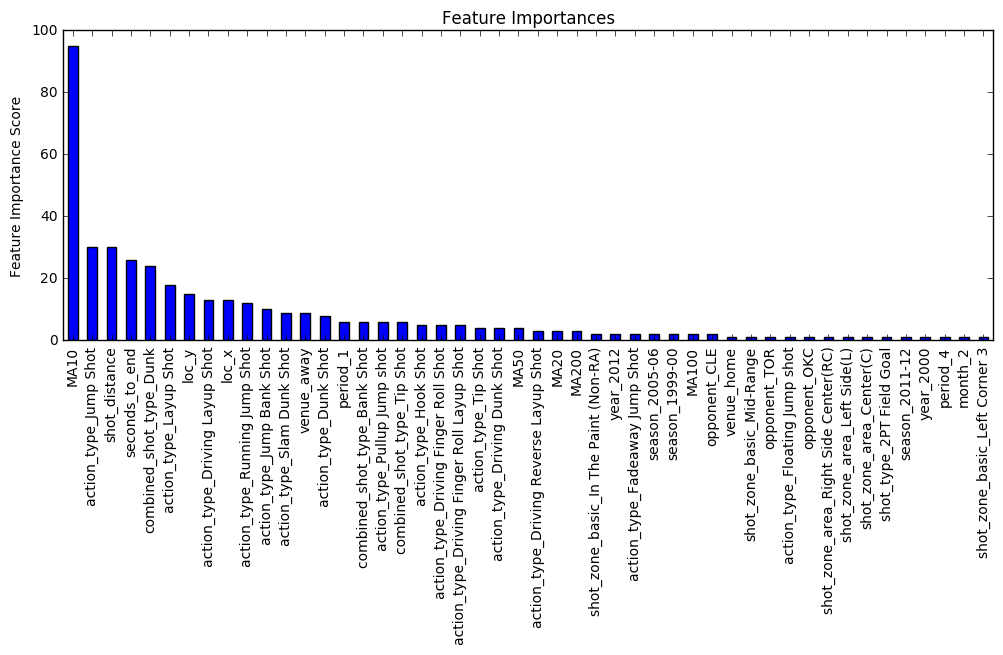

In [28]:
modelfit(best_model, df_train, features, 'shot_made_flag', 'neg_log_loss')

In [29]:
# tune subsample and colsample_bytree
param_test4 = {'subsample':[i/10.0 for i in range(6,10)],
               'colsample_bytree':[i/10.0 for i in range(6,10)]}

best_model = tune_model(best_model, df_train, features, 'shot_made_flag', param_test4, 'neg_log_loss')

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=-0.629505, total=  14.5s
[CV]  colsample_bytree=0.6, subsample=0.6, score=-0.675335, total=  14.5s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=-0.550262, total=  14.8s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=-0.552451, total=  15.2s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=-0.590640, total=  14.1s

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   30.5s


[CV]  colsample_bytree=0.6, subsample=0.6, score=-1.107648, total=  16.0s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=-0.898860, total=  15.5s
[CV]  colsample_bytree=0.6, subsample=0.6, score=-0.563515, total=  16.1s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=-1.468424, total=  15.2s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=-0.550486, total=  14.7s
[CV] colsample_bytree=0.6, subsample=0.7 .............................


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   48.0s


[CV]  colsample_bytree=0.6, subsample=0.7, score=-0.713868, total=  15.0s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=-0.671395, total=  15.3s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=-0.615009, total=  15.3s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=-0.580983, total=  15.2s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=-0.562034, total=  15.5s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=-0.553284, total=  16.0s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=-1.152665, total=  14.4s
[CV] colsample_bytree=0.6, subsample=0.8 ...............

[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.3min


[CV]  colsample_bytree=0.6, subsample=0.7, score=-0.681200, total=  14.1s
[CV]  colsample_bytree=0.6, subsample=0.7, score=-0.889677, total=  14.5s
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=-1.557841, total=  15.3s
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV]  colsample_bytree=0.6, subsample=0.8, score=-0.550283, total=  13.8s
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV]  colsample_bytree=0.6, subsample=0.8, score=-0.733988, total=  13.7s
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV]  colsample_bytree=0.6, subsample=0.8, score=-0.639369, total=  14.0s
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV]  colsample_bytree=0.6, subsample=0.8, score=-0.552260, total=  13.7s
[CV] colsample_bytree=0.6, subsample=0.8 ...............

[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.6min


[CV]  colsample_bytree=0.6, subsample=0.8, score=-0.585252, total=  13.9s
[CV]  colsample_bytree=0.6, subsample=0.8, score=-0.564318, total=  14.7s
[CV]  colsample_bytree=0.6, subsample=0.8, score=-1.165475, total=  13.7s
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV] colsample_bytree=0.6, subsample=0.9 .............................
[CV]  colsample_bytree=0.6, subsample=0.8, score=-0.885246, total=  15.1s
[CV] colsample_bytree=0.6, subsample=0.9 .............................
[CV]  colsample_bytree=0.6, subsample=0.9, score=-0.550136, total=  12.4s
[CV] colsample_bytree=0.6, subsample=0.9 .............................
[CV]  colsample_bytree=0.6, subsample=0.8, score=-0.685747, total=  13.5s
[CV] colsample_bytree=0.6, subsample=0.9 .............................
[CV]  colsample_bytree=0.6, subsample=0.8, score=-1.621345, total=  13.6s
[CV] colsample_bytree=0.6, subsample=0.9 ...............

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.3min


[CV]  colsample_bytree=0.6, subsample=0.9, score=-0.564763, total=  12.8s
[CV] colsample_bytree=0.6, subsample=0.9 .............................
[CV]  colsample_bytree=0.6, subsample=0.9, score=-0.552677, total=  13.0s
[CV] colsample_bytree=0.6, subsample=0.9 .............................
[CV]  colsample_bytree=0.6, subsample=0.9, score=-0.584889, total=  13.2s
[CV] colsample_bytree=0.6, subsample=0.9 .............................
[CV]  colsample_bytree=0.6, subsample=0.9, score=-1.642947, total=  13.1s
[CV]  colsample_bytree=0.6, subsample=0.9, score=-1.195240, total=  13.7s
[CV] colsample_bytree=0.7, subsample=0.6 .............................
[CV] colsample_bytree=0.7, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.9, score=-0.898969, total=  13.5s
[CV] colsample_bytree=0.7, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.9, score=-0.687109, total=  13.4s
[CV] colsample_bytree=0.7, subsample=0.6 ...............

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.8min


[CV] colsample_bytree=0.7, subsample=0.6 .............................
[CV]  colsample_bytree=0.7, subsample=0.6, score=-0.552556, total=  17.7s
[CV] colsample_bytree=0.7, subsample=0.6 .............................
[CV]  colsample_bytree=0.7, subsample=0.6, score=-0.566853, total=  16.6s
[CV] colsample_bytree=0.7, subsample=0.6 .............................
[CV]  colsample_bytree=0.7, subsample=0.6, score=-0.590853, total=  16.2s
[CV] colsample_bytree=0.7, subsample=0.6 .............................
[CV]  colsample_bytree=0.7, subsample=0.6, score=-1.097798, total=  16.0s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.6, score=-0.886270, total=  16.7s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=-0.550366, total=  15.6s
[CV]  colsample_bytree=0.7, subsample=0.6, score=-1.450654, total=  16.1s
[CV] colsample_bytree=0.7, subsample=0.7 ...............

[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  3.6min


[CV]  colsample_bytree=0.7, subsample=0.7, score=-0.565187, total=  15.0s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=-0.629647, total=  15.7s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=-0.582624, total=  16.0s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=-1.505060, total=  15.9s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=-1.104663, total=  17.0s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=-0.935790, total=  17.4s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=-0.685954, total=  16.5s
[CV] colsample_bytree=0.7, subsample=0.8 ...............

[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  4.3min


[CV]  colsample_bytree=0.7, subsample=0.8, score=-0.579870, total=  13.6s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.8, score=-0.564996, total=  14.2s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.8, score=-1.184230, total=  15.9s
[CV] colsample_bytree=0.7, subsample=0.9 .............................
[CV]  colsample_bytree=0.7, subsample=0.8, score=-0.852228, total=  15.0s
[CV] colsample_bytree=0.7, subsample=0.9 .............................
[CV]  colsample_bytree=0.7, subsample=0.8, score=-0.681750, total=  14.8s
[CV] colsample_bytree=0.7, subsample=0.9 .............................
[CV]  colsample_bytree=0.7, subsample=0.8, score=-1.624744, total=  15.1s
[CV] colsample_bytree=0.7, subsample=0.9 .............................
[CV]  colsample_bytree=0.7, subsample=0.9, score=-0.550556, total=  15.4s
[CV] colsample_bytree=0.7, subsample=0.9 ...............

[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  5.2min


[CV]  colsample_bytree=0.7, subsample=0.9, score=-0.881906, total=  14.8s
[CV] colsample_bytree=0.8, subsample=0.6 .............................
[CV]  colsample_bytree=0.7, subsample=0.9, score=-1.641924, total=  14.3s
[CV] colsample_bytree=0.8, subsample=0.6 .............................
[CV]  colsample_bytree=0.7, subsample=0.9, score=-0.686671, total=  14.7s
[CV] colsample_bytree=0.8, subsample=0.6 .............................
[CV]  colsample_bytree=0.8, subsample=0.6, score=-0.550801, total=  17.0s
[CV] colsample_bytree=0.8, subsample=0.6 .............................
[CV]  colsample_bytree=0.8, subsample=0.6, score=-0.669184, total=  18.4s
[CV] colsample_bytree=0.8, subsample=0.6 .............................
[CV]  colsample_bytree=0.8, subsample=0.6, score=-0.611117, total=  18.1s
[CV] colsample_bytree=0.8, subsample=0.6 .............................
[CV]  colsample_bytree=0.8, subsample=0.6, score=-0.552508, total=  17.4s
[CV] colsample_bytree=0.8, subsample=0.6 ...............

[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  6.2min


[CV]  colsample_bytree=0.8, subsample=0.7, score=-0.550767, total=  17.4s
[CV] colsample_bytree=0.8, subsample=0.7 .............................
[CV]  colsample_bytree=0.8, subsample=0.7, score=-0.718040, total=  17.4s
[CV] colsample_bytree=0.8, subsample=0.7 .............................
[CV]  colsample_bytree=0.8, subsample=0.7, score=-0.597765, total=  17.1s
[CV] colsample_bytree=0.8, subsample=0.7 .............................
[CV]  colsample_bytree=0.8, subsample=0.7, score=-0.552978, total=  17.9s
[CV] colsample_bytree=0.8, subsample=0.7 .............................
[CV]  colsample_bytree=0.8, subsample=0.7, score=-0.564518, total=  18.3s
[CV] colsample_bytree=0.8, subsample=0.7 .............................
[CV]  colsample_bytree=0.8, subsample=0.7, score=-0.590716, total=  17.8s
[CV] colsample_bytree=0.8, subsample=0.7 .............................
[CV]  colsample_bytree=0.8, subsample=0.7, score=-1.131043, total=  17.3s
[CV] colsample_bytree=0.8, subsample=0.8 ...............

[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  7.4min


[CV]  colsample_bytree=0.8, subsample=0.8, score=-0.580249, total=  17.9s
[CV] colsample_bytree=0.8, subsample=0.8 .............................
[CV]  colsample_bytree=0.8, subsample=0.8, score=-1.209617, total=  16.3s
[CV] colsample_bytree=0.8, subsample=0.9 .............................
[CV]  colsample_bytree=0.8, subsample=0.8, score=-0.876163, total=  16.7s
[CV] colsample_bytree=0.8, subsample=0.9 .............................
[CV]  colsample_bytree=0.8, subsample=0.8, score=-1.613952, total=  17.5s
[CV] colsample_bytree=0.8, subsample=0.9 .............................
[CV]  colsample_bytree=0.8, subsample=0.9, score=-0.551257, total=  16.2s
[CV] colsample_bytree=0.8, subsample=0.9 .............................
[CV]  colsample_bytree=0.8, subsample=0.8, score=-0.675210, total=  17.2s
[CV] colsample_bytree=0.8, subsample=0.9 .............................
[CV]  colsample_bytree=0.8, subsample=0.9, score=-0.774760, total=  16.6s
[CV] colsample_bytree=0.8, subsample=0.9 ...............

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  8.4min


[CV]  colsample_bytree=0.9, subsample=0.6, score=-0.551156, total=  19.8s
[CV] colsample_bytree=0.9, subsample=0.6 .............................
[CV]  colsample_bytree=0.9, subsample=0.6, score=-0.671817, total=  19.6s
[CV] colsample_bytree=0.9, subsample=0.6 .............................
[CV]  colsample_bytree=0.9, subsample=0.6, score=-0.623028, total=  19.8s
[CV] colsample_bytree=0.9, subsample=0.6 .............................
[CV]  colsample_bytree=0.9, subsample=0.6, score=-0.552979, total=  20.5s
[CV] colsample_bytree=0.9, subsample=0.6 .............................
[CV]  colsample_bytree=0.9, subsample=0.6, score=-0.564096, total=  19.1s
[CV] colsample_bytree=0.9, subsample=0.6 .............................
[CV]  colsample_bytree=0.9, subsample=0.6, score=-0.583133, total=  19.0s
[CV] colsample_bytree=0.9, subsample=0.6 .............................
[CV]  colsample_bytree=0.9, subsample=0.6, score=-1.083924, total=  19.0s
[CV] colsample_bytree=0.9, subsample=0.7 ...............

[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  9.9min


[CV]  colsample_bytree=0.9, subsample=0.7, score=-0.891900, total=  19.2s
[CV] colsample_bytree=0.9, subsample=0.8 .............................
[CV]  colsample_bytree=0.9, subsample=0.7, score=-1.587858, total=  18.0s
[CV] colsample_bytree=0.9, subsample=0.8 .............................
[CV]  colsample_bytree=0.9, subsample=0.7, score=-0.683336, total=  17.9s
[CV] colsample_bytree=0.9, subsample=0.8 .............................
[CV]  colsample_bytree=0.9, subsample=0.8, score=-0.550429, total=  17.6s
[CV] colsample_bytree=0.9, subsample=0.8 .............................
[CV]  colsample_bytree=0.9, subsample=0.8, score=-0.738014, total=  17.4s
[CV] colsample_bytree=0.9, subsample=0.8 .............................
[CV]  colsample_bytree=0.9, subsample=0.8, score=-0.637666, total=  17.7s
[CV] colsample_bytree=0.9, subsample=0.8 .............................
[CV]  colsample_bytree=0.9, subsample=0.8, score=-0.552318, total=  17.5s
[CV] colsample_bytree=0.9, subsample=0.8 ...............

[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed: 11.5min finished


{'param_subsample': masked_array(data = [0.6 0.7 0.8 0.9 0.6 0.7 0.8 0.9 0.6 0.7 0.8 0.9 0.6 0.7 0.8 0.9],
             mask = [False False False False False False False False False False False False
 False False False False],
       fill_value = ?)
, 'split6_train_score': array([-0.54484496, -0.54481205, -0.54536652, -0.54537266, -0.54443213,
       -0.54443012, -0.54514985, -0.54512202, -0.54416113, -0.54459626,
       -0.54484448, -0.54536694, -0.5437518 , -0.54437486, -0.54486506,
       -0.54491057]), 'mean_score_time': array([ 0.11585307,  0.10200689,  0.11486263,  0.13269053,  0.12121   ,
        0.12352028,  0.13704343,  0.12658174,  0.11220374,  0.12085204,
        0.12314065,  0.13470521,  0.11911502,  0.10047905,  0.11880972,
        0.10831835]), 'mean_test_score': array([-0.77080349, -0.78570482, -0.79832835, -0.80970221, -0.76866764,
       -0.78111975, -0.79810037, -0.80985395, -0.76619516, -0.786517  ,
       -0.79897916, -0.80978081, -0.76871471, -0.78585982, -0.799914

In [32]:
# we can fine tune those values with 0.05 interval
param_test5 = {'subsample':[i/100.0 for i in range(70,90,5)],
               'colsample_bytree':[i/100.0 for i in range(50,70,5)]
}

best_model = tune_model(best_model, df_train, features, 'shot_made_flag', param_test5, 'neg_log_loss')

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] colsample_bytree=0.5, subsample=0.7 .............................
[CV] colsample_bytree=0.5, subsample=0.7 .............................
[CV] colsample_bytree=0.5, subsample=0.7 .............................
[CV] colsample_bytree=0.5, subsample=0.7 .............................
[CV]  colsample_bytree=0.5, subsample=0.7, score=-0.553324, total=  10.8s
[CV]  colsample_bytree=0.5, subsample=0.7, score=-0.550133, total=  11.0s
[CV] colsample_bytree=0.5, subsample=0.7 .............................
[CV] colsample_bytree=0.5, subsample=0.7 .............................
[CV]  colsample_bytree=0.5, subsample=0.7, score=-0.712067, total=  11.1s
[CV] colsample_bytree=0.5, subsample=0.7 .............................
[CV]  colsample_bytree=0.5, subsample=0.7, score=-0.620754, total=  11.0s
[CV] colsample_bytree=0.5, subsample=0.7 .............................
[CV]  colsample_bytree=0.5, subsample=0.7, score=-0.588850, total=  12.5s

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   25.0s


[CV] colsample_bytree=0.5, subsample=0.7 .............................
[CV]  colsample_bytree=0.5, subsample=0.7, score=-1.121909, total=  12.7s
[CV] colsample_bytree=0.5, subsample=0.75 ............................
[CV]  colsample_bytree=0.5, subsample=0.7, score=-0.564531, total=  13.0s
[CV] colsample_bytree=0.5, subsample=0.75 ............................
[CV]  colsample_bytree=0.5, subsample=0.7, score=-0.683039, total=  11.8s
[CV] colsample_bytree=0.5, subsample=0.75 ............................
[CV]  colsample_bytree=0.5, subsample=0.7, score=-1.561069, total=  12.3s
[CV] colsample_bytree=0.5, subsample=0.75 ............................
[CV]  colsample_bytree=0.5, subsample=0.75, score=-0.550635, total=  12.3s


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   38.2s


[CV] colsample_bytree=0.5, subsample=0.75 ............................
[CV]  colsample_bytree=0.5, subsample=0.75, score=-0.738027, total=  12.4s
[CV] colsample_bytree=0.5, subsample=0.75 ............................
[CV]  colsample_bytree=0.5, subsample=0.75, score=-0.552277, total=  12.3s
[CV] colsample_bytree=0.5, subsample=0.75 ............................
[CV]  colsample_bytree=0.5, subsample=0.75, score=-0.566132, total=  11.9s
[CV]  colsample_bytree=0.5, subsample=0.75, score=-0.622628, total=  12.5s
[CV] colsample_bytree=0.5, subsample=0.75 ............................
[CV] colsample_bytree=0.5, subsample=0.75 ............................
[CV]  colsample_bytree=0.5, subsample=0.75, score=-0.585658, total=  12.6s
[CV] colsample_bytree=0.5, subsample=0.75 ............................
[CV]  colsample_bytree=0.5, subsample=0.75, score=-1.642777, total=  11.1s
[CV] colsample_bytree=0.5, subsample=0.8 .............................


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.1min


[CV]  colsample_bytree=0.5, subsample=0.75, score=-1.158528, total=  11.9s
[CV] colsample_bytree=0.5, subsample=0.8 .............................
[CV]  colsample_bytree=0.5, subsample=0.75, score=-0.871795, total=  12.8s
[CV] colsample_bytree=0.5, subsample=0.8 .............................
[CV]  colsample_bytree=0.5, subsample=0.75, score=-0.685674, total=  12.4s
[CV] colsample_bytree=0.5, subsample=0.8 .............................
[CV]  colsample_bytree=0.5, subsample=0.8, score=-0.550440, total=  12.0s
[CV] colsample_bytree=0.5, subsample=0.8 .............................
[CV]  colsample_bytree=0.5, subsample=0.8, score=-0.734301, total=  12.2s
[CV] colsample_bytree=0.5, subsample=0.8 .............................
[CV]  colsample_bytree=0.5, subsample=0.8, score=-0.552297, total=  12.6s
[CV]  colsample_bytree=0.5, subsample=0.8, score=-0.643409, total=  12.5s
[CV] colsample_bytree=0.5, subsample=0.8 .............................
[CV] colsample_bytree=0.5, subsample=0.8 ............

[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.3min


[CV]  colsample_bytree=0.5, subsample=0.8, score=-0.566008, total=  13.1s
[CV] colsample_bytree=0.5, subsample=0.8 .............................
[CV]  colsample_bytree=0.5, subsample=0.8, score=-0.586282, total=  12.8s
[CV] colsample_bytree=0.5, subsample=0.8 .............................
[CV]  colsample_bytree=0.5, subsample=0.8, score=-1.165224, total=  12.6s
[CV] colsample_bytree=0.5, subsample=0.85 ............................
[CV]  colsample_bytree=0.5, subsample=0.8, score=-0.872318, total=  12.8s
[CV] colsample_bytree=0.5, subsample=0.85 ............................
[CV]  colsample_bytree=0.5, subsample=0.8, score=-1.642705, total=  11.0s
[CV] colsample_bytree=0.5, subsample=0.85 ............................
[CV]  colsample_bytree=0.5, subsample=0.8, score=-0.688193, total=  10.8s
[CV] colsample_bytree=0.5, subsample=0.85 ............................
[CV]  colsample_bytree=0.5, subsample=0.85, score=-0.549918, total=  10.5s
[CV] colsample_bytree=0.5, subsample=0.85 .............

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.9min


[CV]  colsample_bytree=0.5, subsample=0.85, score=-0.638438, total=  11.5s
[CV] colsample_bytree=0.5, subsample=0.85 ............................
[CV]  colsample_bytree=0.5, subsample=0.85, score=-0.563817, total=  11.9s
[CV] colsample_bytree=0.5, subsample=0.85 ............................
[CV]  colsample_bytree=0.5, subsample=0.85, score=-0.595883, total=  12.1s
[CV] colsample_bytree=0.5, subsample=0.85 ............................
[CV]  colsample_bytree=0.5, subsample=0.85, score=-1.183621, total=  10.7s
[CV] colsample_bytree=0.55, subsample=0.7 ............................
[CV]  colsample_bytree=0.5, subsample=0.85, score=-0.870477, total=  10.5s
[CV] colsample_bytree=0.55, subsample=0.7 ............................
[CV]  colsample_bytree=0.5, subsample=0.85, score=-1.642634, total=  10.6s
[CV] colsample_bytree=0.55, subsample=0.7 ............................
[CV]  colsample_bytree=0.5, subsample=0.85, score=-0.679710, total=  11.0s
[CV] colsample_bytree=0.55, subsample=0.7 .......

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.3min


[CV] colsample_bytree=0.55, subsample=0.7 ............................
[CV]  colsample_bytree=0.55, subsample=0.7, score=-0.554227, total=  13.5s
[CV] colsample_bytree=0.55, subsample=0.7 ............................
[CV]  colsample_bytree=0.55, subsample=0.7, score=-0.566171, total=  12.4s
[CV] colsample_bytree=0.55, subsample=0.7 ............................
[CV]  colsample_bytree=0.55, subsample=0.7, score=-1.100464, total=  11.9s
[CV] colsample_bytree=0.55, subsample=0.7 ............................
[CV]  colsample_bytree=0.55, subsample=0.7, score=-0.587365, total=  12.3s
[CV] colsample_bytree=0.55, subsample=0.75 ...........................
[CV]  colsample_bytree=0.55, subsample=0.7, score=-0.868982, total=  12.1s
[CV] colsample_bytree=0.55, subsample=0.75 ...........................
[CV]  colsample_bytree=0.55, subsample=0.7, score=-1.584158, total=  12.6s
[CV] colsample_bytree=0.55, subsample=0.75 ...........................
[CV]  colsample_bytree=0.55, subsample=0.75, score=-0

[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  3.0min


[CV]  colsample_bytree=0.55, subsample=0.75, score=-0.553968, total=  12.7s
[CV] colsample_bytree=0.55, subsample=0.75 ...........................
[CV]  colsample_bytree=0.55, subsample=0.75, score=-0.564185, total=  12.8s
[CV] colsample_bytree=0.55, subsample=0.75 ...........................
[CV]  colsample_bytree=0.55, subsample=0.75, score=-0.589522, total=  12.2s
[CV] colsample_bytree=0.55, subsample=0.75 ...........................
[CV]  colsample_bytree=0.55, subsample=0.75, score=-1.145557, total=  12.2s
[CV] colsample_bytree=0.55, subsample=0.8 ............................
[CV]  colsample_bytree=0.55, subsample=0.75, score=-0.846866, total=  11.9s
[CV] colsample_bytree=0.55, subsample=0.8 ............................
[CV]  colsample_bytree=0.55, subsample=0.75, score=-1.591684, total=  11.8s
[CV] colsample_bytree=0.55, subsample=0.8 ............................
[CV]  colsample_bytree=0.55, subsample=0.75, score=-0.679313, total=  12.2s
[CV] colsample_bytree=0.55, subsample=0.8 

[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  3.5min


[CV]  colsample_bytree=0.55, subsample=0.8, score=-0.567709, total=  11.5s
[CV] colsample_bytree=0.55, subsample=0.8 ............................
[CV]  colsample_bytree=0.55, subsample=0.8, score=-1.170000, total=  11.5s
[CV] colsample_bytree=0.55, subsample=0.8 ............................
[CV]  colsample_bytree=0.55, subsample=0.8, score=-0.587761, total=  11.7s
[CV] colsample_bytree=0.55, subsample=0.85 ...........................
[CV]  colsample_bytree=0.55, subsample=0.8, score=-0.869351, total=  11.0s
[CV] colsample_bytree=0.55, subsample=0.85 ...........................
[CV]  colsample_bytree=0.55, subsample=0.8, score=-1.633105, total=  12.7s
[CV] colsample_bytree=0.55, subsample=0.85 ...........................
[CV]  colsample_bytree=0.55, subsample=0.8, score=-0.694782, total=  12.7s
[CV] colsample_bytree=0.55, subsample=0.85 ...........................
[CV]  colsample_bytree=0.55, subsample=0.85, score=-0.550059, total=  12.7s
[CV] colsample_bytree=0.55, subsample=0.85 .....

[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  4.3min


[CV]  colsample_bytree=0.55, subsample=0.85, score=-1.596952, total=  12.0s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.55, subsample=0.85, score=-0.881353, total=  12.3s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.55, subsample=0.85, score=-0.676824, total=  12.9s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=-0.713868, total=  12.9s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=-0.550486, total=  14.0s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=-0.615009, total=  13.7s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=-0.553284, total=  13.8s
[CV] colsample_bytree=0.6, subsample=0.7 .........

[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  5.0min


[CV]  colsample_bytree=0.6, subsample=0.7, score=-0.681200, total=  13.2s
[CV] colsample_bytree=0.6, subsample=0.75 ............................
[CV]  colsample_bytree=0.6, subsample=0.75, score=-0.735952, total=  12.9s
[CV] colsample_bytree=0.6, subsample=0.75 ............................
[CV]  colsample_bytree=0.6, subsample=0.75, score=-0.644681, total=  12.5s
[CV] colsample_bytree=0.6, subsample=0.75 ............................
[CV]  colsample_bytree=0.6, subsample=0.75, score=-0.553915, total=  12.6s
[CV] colsample_bytree=0.6, subsample=0.75 ............................
[CV]  colsample_bytree=0.6, subsample=0.75, score=-0.563390, total=  12.8s
[CV] colsample_bytree=0.6, subsample=0.75 ............................
[CV]  colsample_bytree=0.6, subsample=0.75, score=-0.586863, total=  12.7s
[CV] colsample_bytree=0.6, subsample=0.75 ............................
[CV]  colsample_bytree=0.6, subsample=0.75, score=-1.148482, total=  12.7s
[CV] colsample_bytree=0.6, subsample=0.8 .........

[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  5.9min


[CV]  colsample_bytree=0.6, subsample=0.8, score=-0.564318, total=  12.7s
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV]  colsample_bytree=0.6, subsample=0.8, score=-1.165475, total=  12.5s
[CV] colsample_bytree=0.6, subsample=0.85 ............................
[CV]  colsample_bytree=0.6, subsample=0.8, score=-0.885246, total=  13.3s
[CV] colsample_bytree=0.6, subsample=0.85 ............................
[CV]  colsample_bytree=0.6, subsample=0.8, score=-1.621345, total=  13.2s
[CV] colsample_bytree=0.6, subsample=0.85 ............................
[CV]  colsample_bytree=0.6, subsample=0.8, score=-0.685747, total=  13.6s
[CV] colsample_bytree=0.6, subsample=0.85 ............................
[CV]  colsample_bytree=0.6, subsample=0.85, score=-0.550600, total=  13.0s
[CV] colsample_bytree=0.6, subsample=0.85 ............................
[CV]  colsample_bytree=0.6, subsample=0.85, score=-0.758100, total=  12.5s
[CV] colsample_bytree=0.6, subsample=0.85 ............

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  6.7min


[CV]  colsample_bytree=0.65, subsample=0.7, score=-0.699535, total=  13.3s
[CV] colsample_bytree=0.65, subsample=0.7 ............................
[CV]  colsample_bytree=0.65, subsample=0.7, score=-0.550804, total=  13.5s
[CV] colsample_bytree=0.65, subsample=0.7 ............................
[CV]  colsample_bytree=0.65, subsample=0.7, score=-0.626303, total=  13.4s
[CV] colsample_bytree=0.65, subsample=0.7 ............................
[CV]  colsample_bytree=0.65, subsample=0.7, score=-0.554227, total=  14.1s
[CV] colsample_bytree=0.65, subsample=0.7 ............................
[CV]  colsample_bytree=0.65, subsample=0.7, score=-0.567277, total=  13.1s
[CV] colsample_bytree=0.65, subsample=0.7 ............................
[CV]  colsample_bytree=0.65, subsample=0.7, score=-0.578807, total=  13.8s
[CV] colsample_bytree=0.65, subsample=0.7 ............................
[CV]  colsample_bytree=0.65, subsample=0.7, score=-1.123580, total=  14.0s
[CV] colsample_bytree=0.65, subsample=0.75 ......

[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  7.8min


[CV]  colsample_bytree=0.65, subsample=0.75, score=-0.887132, total=  13.8s
[CV] colsample_bytree=0.65, subsample=0.8 ............................
[CV]  colsample_bytree=0.65, subsample=0.75, score=-1.594479, total=  13.6s
[CV] colsample_bytree=0.65, subsample=0.8 ............................
[CV]  colsample_bytree=0.65, subsample=0.75, score=-0.692972, total=  15.2s
[CV] colsample_bytree=0.65, subsample=0.8 ............................
[CV]  colsample_bytree=0.65, subsample=0.8, score=-0.737827, total=  15.8s
[CV]  colsample_bytree=0.65, subsample=0.8, score=-0.549904, total=  16.3s
[CV] colsample_bytree=0.65, subsample=0.8 ............................
[CV] colsample_bytree=0.65, subsample=0.8 ............................
[CV]  colsample_bytree=0.65, subsample=0.8, score=-0.647842, total=  16.8s
[CV] colsample_bytree=0.65, subsample=0.8 ............................
[CV]  colsample_bytree=0.65, subsample=0.8, score=-0.552739, total=  16.9s
[CV] colsample_bytree=0.65, subsample=0.8 ....

[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:  9.2min finished


{'colsample_bytree': 0.65, 'subsample': 0.7}
-0.781674887514


In [34]:
best_model

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.65,
       gamma=0.2, learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=6, missing=None, n_estimators=140, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.7)

In [35]:
# tunning regularization parameters
param_test6 = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}

best_model = tune_model(best_model, df_train, features, 'shot_made_flag', param_test6, 'neg_log_loss')

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] reg_alpha=1e-05 .................................................
[CV] reg_alpha=1e-05 .................................................
[CV] reg_alpha=1e-05 .................................................
[CV] reg_alpha=1e-05 .................................................
[CV] ................. reg_alpha=1e-05, score=-0.550804, total=  14.0s
[CV] reg_alpha=1e-05 .................................................
[CV] ................. reg_alpha=1e-05, score=-0.554227, total=  14.1s
[CV] reg_alpha=1e-05 .................................................
[CV] ................. reg_alpha=1e-05, score=-0.626303, total=  14.5s
[CV] reg_alpha=1e-05 .................................................
[CV] ................. reg_alpha=1e-05, score=-0.699535, total=  14.7s
[CV] reg_alpha=1e-05 .................................................
[CV] ................. reg_alpha=1e-05, score=-0.567277, total=  13.7s
[CV] reg_alpha=1

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   29.4s


[CV] ................. reg_alpha=1e-05, score=-0.578807, total=  14.1s
[CV] reg_alpha=1e-05 .................................................
[CV] ................. reg_alpha=1e-05, score=-1.123580, total=  14.2s
[CV] reg_alpha=0.01 ..................................................
[CV] ................. reg_alpha=1e-05, score=-0.874272, total=  14.3s
[CV] reg_alpha=0.01 ..................................................
[CV] ................. reg_alpha=1e-05, score=-1.564868, total=  14.0s
[CV] reg_alpha=0.01 ..................................................
[CV] ................. reg_alpha=1e-05, score=-0.677074, total=  14.1s
[CV] reg_alpha=0.01 ..................................................
[CV] .................. reg_alpha=0.01, score=-0.550807, total=  13.8s
[CV] reg_alpha=0.01 ..................................................


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   44.9s


[CV] .................. reg_alpha=0.01, score=-0.699357, total=  14.0s
[CV] reg_alpha=0.01 ..................................................
[CV] .................. reg_alpha=0.01, score=-0.554229, total=  12.2s
[CV] reg_alpha=0.01 ..................................................
[CV] .................. reg_alpha=0.01, score=-0.567274, total=  13.4s
[CV] reg_alpha=0.01 ..................................................
[CV] .................. reg_alpha=0.01, score=-0.580704, total=  13.7s
[CV] reg_alpha=0.01 ..................................................
[CV] .................. reg_alpha=0.01, score=-0.626231, total=  15.0s
[CV] reg_alpha=0.01 ..................................................
[CV] .................. reg_alpha=0.01, score=-1.123161, total=  13.7s
[CV] reg_alpha=0.1 ...................................................


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.2min


[CV] .................. reg_alpha=0.01, score=-0.872529, total=  13.8s
[CV] reg_alpha=0.1 ...................................................
[CV] .................. reg_alpha=0.01, score=-1.564198, total=  13.8s
[CV] reg_alpha=0.1 ...................................................
[CV] .................. reg_alpha=0.01, score=-0.678797, total=  14.1s
[CV] reg_alpha=0.1 ...................................................
[CV] ................... reg_alpha=0.1, score=-0.550892, total=  13.5s
[CV] reg_alpha=0.1 ...................................................
[CV] ................... reg_alpha=0.1, score=-0.697104, total=  13.5s
[CV] reg_alpha=0.1 ...................................................
[CV] ................... reg_alpha=0.1, score=-0.624104, total=  12.5s
[CV] reg_alpha=0.1 ...................................................
[CV] ................... reg_alpha=0.1, score=-0.553993, total=  14.7s
[CV] reg_alpha=0.1 ...................................................


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.5min


[CV] ................... reg_alpha=0.1, score=-0.567201, total=  13.6s
[CV] reg_alpha=0.1 ...................................................
[CV] ................... reg_alpha=0.1, score=-1.131039, total=  14.1s
[CV] reg_alpha=0.1 ...................................................
[CV] ................... reg_alpha=0.1, score=-0.578230, total=  14.2s
[CV] reg_alpha=1 .....................................................
[CV] ................... reg_alpha=0.1, score=-0.881648, total=  13.5s
[CV] reg_alpha=1 .....................................................
[CV] ................... reg_alpha=0.1, score=-1.572342, total=  13.4s
[CV] reg_alpha=1 .....................................................
[CV] ..................... reg_alpha=1, score=-0.551606, total=  13.8s
[CV] reg_alpha=1 .....................................................
[CV] ................... reg_alpha=0.1, score=-0.676648, total=  14.5s
[CV] reg_alpha=1 .....................................................
[CV] .

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.2min


[CV] ..................... reg_alpha=1, score=-0.565038, total=  14.2s
[CV] ..................... reg_alpha=1, score=-0.602596, total=  16.0s
[CV] reg_alpha=1 .....................................................
[CV] reg_alpha=1 .....................................................
[CV] ..................... reg_alpha=1, score=-0.579020, total=  16.4s
[CV] reg_alpha=1 .....................................................
[CV] ..................... reg_alpha=1, score=-0.869459, total=  14.0s
[CV] reg_alpha=100 ...................................................
[CV] ..................... reg_alpha=1, score=-1.048292, total=  16.1s
[CV] reg_alpha=100 ...................................................
[CV] ..................... reg_alpha=1, score=-1.517043, total=  16.1s
[CV] reg_alpha=100 ...................................................
[CV] ..................... reg_alpha=1, score=-0.673084, total=  15.1s
[CV] reg_alpha=100 ...................................................
[CV] .

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.8min


[CV] ................... reg_alpha=100, score=-0.560954, total=  15.9s
[CV] reg_alpha=100 ...................................................
[CV] ................... reg_alpha=100, score=-0.572002, total=  16.0s
[CV] reg_alpha=100 ...................................................
[CV] ................... reg_alpha=100, score=-0.571768, total=  15.4s
[CV] reg_alpha=100 ...................................................
[CV] ................... reg_alpha=100, score=-0.568598, total=  15.0s
[CV] reg_alpha=100 ...................................................
[CV] ................... reg_alpha=100, score=-0.572702, total=  16.7s
[CV] ................... reg_alpha=100, score=-0.577072, total=  15.4s
[CV] ................... reg_alpha=100, score=-0.579347, total=  10.4s
[CV] ................... reg_alpha=100, score=-0.567004, total=   9.9s


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  3.2min finished


{'reg_alpha': 100}
-0.571156696429


In [37]:
best_model

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.65,
       gamma=0.2, learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=6, missing=None, n_estimators=140, nthread=4,
       objective='binary:logistic', reg_alpha=100, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.7)


Model Report
Accuracy: 0.7075
AUC Score (Train): 0.772274
CV score (neg_log_loss): Mean - -0.5728969 | Std - 0.002313978 | Min - -0.5761956 | Max - -0.5692152


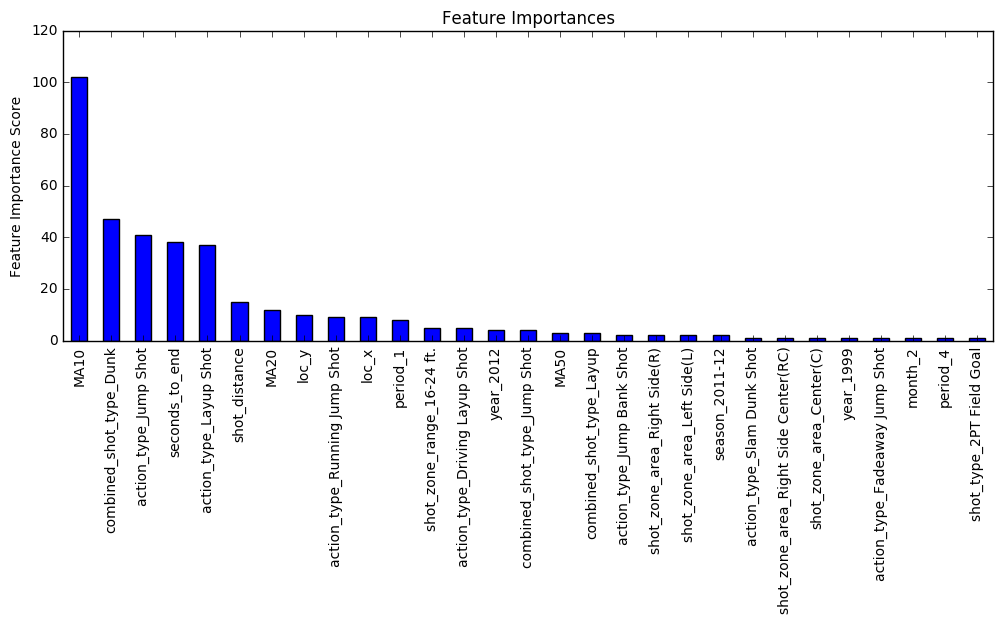

In [36]:
modelfit(best_model, df_train, features, 'shot_made_flag', 'neg_log_loss')


Model Report
Accuracy: 0.7069
AUC Score (Train): 0.771245
CV score (neg_log_loss): Mean - -0.5740002 | Std - 0.001694571 | Min - -0.5762131 | Max - -0.5710451


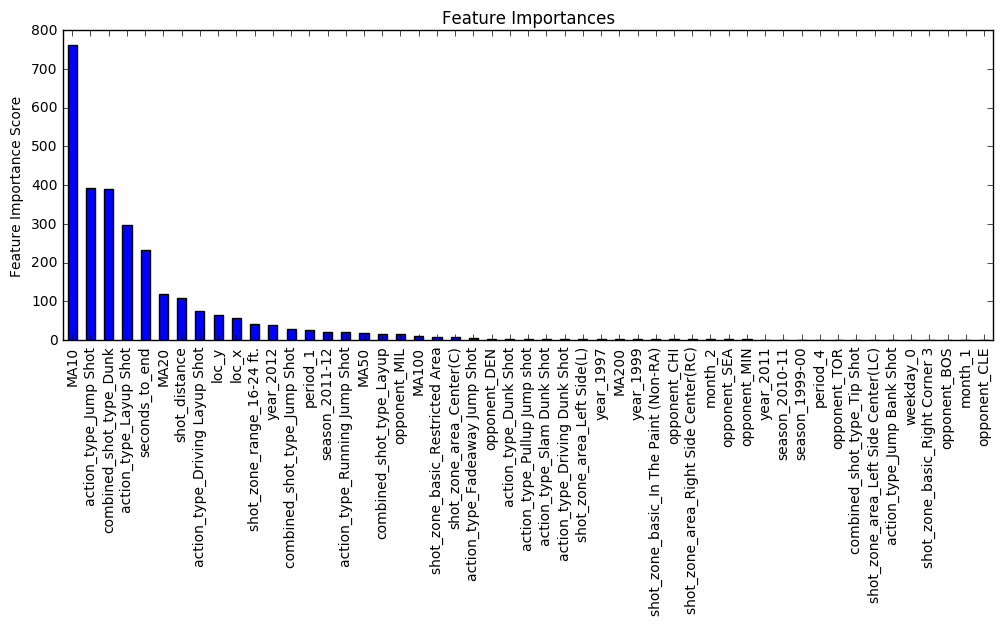

In [39]:
# reducing learning rate
xgb_test = XGBClassifier(base_score=0.5, 
                    colsample_bylevel=1, 
                    colsample_bytree=0.65,
                    gamma=0.2, 
                    learning_rate=0.01, 
                    max_delta_step=0, 
                    max_depth=2,
                    min_child_weight=6, 
                    missing=None, 
                    n_estimators=1000, 
                    nthread=4,
                    objective='binary:logistic', 
                    reg_alpha=100, 
                    reg_lambda=1,
                    scale_pos_weight=1, 
                    seed=27, 
                    silent=True, 
                    subsample=0.7)

modelfit(xgb_test, df_train, features, 'shot_made_flag', 'neg_log_loss')

## Predictions

In [4]:
# import the data
df = pd.read_pickle('../input/processed_data.pickle')

xgb = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.65,
       gamma=0.2, learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=6, missing=None, n_estimators=140, nthread=4,
       objective='binary:logistic', reg_alpha=100, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.7)

# We need an index to filter examples prior to the prediction.
# At this point, the dataframe is already sorted chronologically.
# We just need to reset the index
df.reset_index(inplace=True)

# There are some NaN in moving averages features.
# we replace them with 0.4 (the average success rate of kobe)
columns = ['MA10','MA20','MA50','MA100','MA200']

for col in columns:
    df[col].fillna(0.4, inplace=True)
    
# We now split the dataframe into a training set and a test set
df_train = df.dropna(subset=['shot_made_flag'])
df_test = df[df['shot_made_flag'].isnull()]

# We remove the shot_made_flag from the test set
# All values are NaN
df_test.drop(['shot_made_flag'],axis=1,inplace=True)

/home/guillaume/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
import time
import csv
import warnings; warnings.simplefilter('ignore')

start = time.time()

i = 1

for index, row in df_test.iterrows():
    shot_id = df_test.get_value(index, 'shot_id')
    
    prediction_start = time.time()
      
    
    # create a subset to train the classifier
    train_subset = df_train[df_train.index < index]
    
    X = np.array(train_subset.drop(['shot_id','shot_made_flag','game_date'], axis=1))
    y = np.array(train_subset['shot_made_flag'])
    
    xgb.fit(X,y)
    
    # make prediction for row
    X_test = np.array(df_test.drop(['shot_id','game_date'], axis=1).loc[index])
    
    # xgboost is expecting a 2D array (n samples, n features). As we are predicting
    # one record at a time, we need to reshape our array
    X_test = np.array(X_test).reshape((1,-1))
    
    y_sub = xgb.predict_proba(X_test)
    
    print('Prediction # ' + str(i) + ', index = ' + str(index) + ', shot_id = ' + str(shot_id) + ', time = ' + str(time.time() - prediction_start))
    i += 1
    
    # save the prediction to a csv file    
    file = '../submissions/sub-xgboost-2017-03-22-01.csv'
    with open(file, 'a') as f:
        writer = csv.writer(f)
        # The second predicted value is the one we want
        # P(shot successful)
        writer.writerow([shot_id,y_sub[0][1]])
        
print('finished in ' + str(time.time() - start) + ' seconds.')


Prediction # 1, index = 5, shot_id = 22907, time = 0.12198519706726074
Prediction # 2, index = 7, shot_id = 22909, time = 0.04043459892272949
Prediction # 3, index = 24, shot_id = 22926, time = 0.12244749069213867
Prediction # 4, index = 25, shot_id = 22927, time = 0.13004159927368164
Prediction # 5, index = 28, shot_id = 22930, time = 0.0845038890838623
Prediction # 6, index = 32, shot_id = 22934, time = 0.046358346939086914
Prediction # 7, index = 35, shot_id = 22937, time = 0.042402029037475586
Prediction # 8, index = 37, shot_id = 22939, time = 0.13379383087158203
Prediction # 9, index = 47, shot_id = 22949, time = 0.09083271026611328
Prediction # 10, index = 49, shot_id = 22951, time = 0.04380917549133301
Prediction # 11, index = 53, shot_id = 22955, time = 0.044677734375
Prediction # 12, index = 63, shot_id = 22965, time = 0.14586567878723145
Prediction # 13, index = 64, shot_id = 22966, time = 0.08405685424804688
Prediction # 14, index = 66, shot_id = 22968, time = 0.04429531097

The submission got a score of **0.64578** ranking **734/1117**